In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import os

def blur_image(image, blur_kernel_size):
    """
    Aplica un filtro de desenfoque gaussiano a una imagen.

    :param image: Imagen de entrada, puede ser en escala de grises o en color.
    :param blur_kernel_size: Tamaño del kernel de desenfoque. Debe ser un número impar.
    :return: Imagen desenfocada en escala de grises.
    """
    if len(image.shape) > 2 and image.shape[2] > 1:
        # Si la imagen tiene más de un canal, conviértela a escala de grises
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        # Si la imagen ya está en escala de grises, no es necesario convertirla
        grayscale_image = image
    else:
        # Si el formato de la imagen no es compatible, lanza una excepción
        raise ValueError("Unsupported image format")

    # Aplica un filtro de desenfoque gaussiano
    blurred_image = cv2.GaussianBlur(grayscale_image, (blur_kernel_size, blur_kernel_size), 0)
    
    return blurred_image


def compare_binary_images(image1, image2):
    """
    Compara dos imágenes binarias y devuelve el porcentaje de similitud.

    :param image1: Primera imagen binaria.
    :param image2: Segunda imagen binaria.
    :return: Porcentaje de similitud entre las dos imágenes.
    """
    # Asegurarse de que las imágenes tengan las mismas dimensiones
    if image1.shape != image2.shape:
        raise ValueError("Las dos imágenes deben tener las mismas dimensiones.")

    # Calcular el número de píxeles coincidentes
    matching_pixels = np.sum(image1 == image2)
    total_pixels = image1.shape[0] * image1.shape[1]

    # Calcular el porcentaje de similitud
    similarity_percentage = (matching_pixels / total_pixels) * 100

    return similarity_percentage


def filtrar_color_amarillo(imagen):
    """
    Filtra el color amarillo de una imagen y devuelve una máscara binaria y la imagen resultante con solo el color amarillo.

    :param imagen: Imagen de entrada en formato BGR.
    :return: Una tupla que contiene la máscara binaria y la imagen resultante con solo el color amarillo.
    """
    # Convertir la imagen a formato HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Definir el rango de colores amarillos en HSV
    lower_yellow = np.array([18, 100, 100])
    upper_yellow = np.array([26, 255, 255])
    
    # Aplicar el filtro para detectar solo el color amarillo
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Crear una imagen binaria utilizando la máscara
    resultado = cv2.bitwise_and(imagen, imagen, mask=mask)
    
    return mask, resultado


def remove_small_particles(binary_image, min_area):
    """
    Elimina las partículas pequeñas de una imagen binaria basándose en un área mínima especificada.

    :param binary_image: Imagen binaria de entrada.
    :param min_area: Área mínima para que una partícula sea conservada.
    :return: Imagen binaria con las partículas pequeñas eliminadas.
    """
    # Encontrar contornos en la imagen binaria
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crear una máscara para almacenar las partículas filtradas
    filtered_mask = np.zeros_like(binary_image)
    
    # Iterar a través de los contornos
    for contour in contours:
        # Calcular el área del contorno
        area = cv2.contourArea(contour)
        
        # Si el área es mayor o igual al umbral de área mínima, conservar el contorno
        if area >= min_area:
            cv2.drawContours(filtered_mask, [contour], -1, 255, cv2.FILLED)
    
    return filtered_mask






def remove_small_particles2(binary_image, min_area):
    """
    Elimina las partículas pequeñas de una imagen binaria basándose en un área mínima especificada y
    devuelve una máscara filtrada junto con las posiciones y áreas de las partículas conservadas.

    :param binary_image: Imagen binaria de entrada.
    :param min_area: Área mínima para que una partícula sea conservada.
    :return: Una tupla que contiene la máscara filtrada, las posiciones y las áreas de las partículas conservadas.
    """
    # Encontrar contornos en la imagen binaria
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crear listas para almacenar las posiciones y áreas de las partículas
    particle_positions = []
    particle_areas = []
    
    # Crear una máscara para almacenar las partículas filtradas
    filtered_mask = np.zeros_like(binary_image)
    
    # Iterar a través de los contornos
    for contour in contours:
        # Calcular el área del contorno
        area = cv2.contourArea(contour)
        
        # Si el área es mayor o igual al umbral de área mínima, conservar el contorno
        if area >= min_area:
            # Obtener el centroide del contorno
            M = cv2.moments(contour)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            
            # Agregar posición y área a las listas
            particle_positions.append([cx, cy])
            particle_areas.append(area)
            
            # Dibujar el contorno en la máscara filtrada
            cv2.drawContours(filtered_mask, [contour], -1, 255, cv2.FILLED)
    
    # Convertir las listas a arreglos de NumPy
    particle_positions = np.array(particle_positions)
    particle_areas = np.array(particle_areas)
    
    return filtered_mask, particle_positions, particle_areas


def expand_binary_zone(binary_image, iterations=1):
    """
    Expande las zonas binarias en una imagen aplicando la operación de dilatación.

    :param binary_image: Imagen binaria de entrada.
    :param iterations: Número de iteraciones para la operación de dilatación (por defecto es 1).
    :return: Imagen binaria con las zonas expandidas.
    """
    # Definir el kernel para la operación de dilatación
    kernel = np.ones((3, 3), np.uint8)
    
    # Aplicar la operación de dilatación
    expanded_image = cv2.dilate(binary_image, kernel, iterations=iterations)
    
    return expanded_image




def shrink_binary_zone(binary_image, iterations=1):
    """
    Reduce las zonas binarias en una imagen aplicando la operación de erosión.

    :param binary_image: Imagen binaria de entrada.
    :param iterations: Número de iteraciones para la operación de erosión (por defecto es 1).
    :return: Imagen binaria con las zonas reducidas.
    """
    # Definir el kernel para la operación de erosión
    kernel = np.ones((3, 3), np.uint8)
    
    # Aplicar la operación de erosión
    shrunk_image = cv2.erode(binary_image, kernel, iterations=iterations)
    
    return shrunk_image

def filtering_1(imagen, mode=0, dif=3, bordes=1):
    """
    Aplica un filtro de color amarillo, elimina partículas pequeñas, expande y reduce zonas binarias,
    y detecta bordes en la imagen.

    :param imagen: Imagen de entrada en formato BGR.
    :param mode: Modo de visualización (0 para no mostrar, cualquier otro valor para mostrar las imágenes intermedias).
    :param dif: Número de iteraciones para las operaciones de dilatación y erosión.
    :param bordes: Indica si se deben detectar los bordes (1 para detectar bordes con Canny, 0 para mantener la imagen filtrada).
    :return: Una tupla que contiene la imagen con bordes detectados y la imagen binaria filtrada.
    """
    # Filtrar el color amarillo de la imagen
    mask_amarillo, resultado_amarillo = filtrar_color_amarillo(imagen)
    
    # Establecer el umbral mínimo de área
    height, width = mask_amarillo.shape
    min_area_threshold = int(height * width * 0.005)

    # Eliminar partículas pequeñas de la imagen binaria
    filtered_image, areas, positions = remove_small_particles2(mask_amarillo, min_area_threshold)

    # Mostrar imágenes intermedias si mode no es 0
    if mode != 0:
        cv2.imshow('Original', imagen)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Máscara Amarilla', mask_amarillo)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Expandir las zonas binarias
    filtered_image = expand_binary_zone(filtered_image, dif)

    # Mostrar imagen filtrada expandida si mode no es 0
    if mode != 0:
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Reducir las zonas binarias
    filtered_image = shrink_binary_zone(filtered_image, dif)

    # Mostrar imagen filtrada reducida si mode no es 0
    if mode != 0:
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Detectar bordes si bordes es 1, de lo contrario, mantener la imagen filtrada
    if bordes == 1:
        bordes = cv2.Canny(filtered_image, 100, 200)
    else:
        bordes = filtered_image

    # Mostrar la imagen con bordes si mode no es 0
    if mode != 0:
        cv2.imshow('Bordes', bordes)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return bordes, filtered_image


def centroid_and_area(binary_image):
    """
    Calcula los centroides y áreas de los contornos en una imagen binaria.

    :param binary_image: Imagen binaria de entrada.
    :return: Una tupla que contiene una lista de centroides (coordenadas x, y) y una lista de áreas de los contornos.
    """
    # Encuentra los contornos en la imagen binaria
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centroids = []
    areas = []
    
    # Itera sobre los contornos encontrados
    for contour in contours:
        # Calcula el centroide del contorno
        M = cv2.moments(contour)
        if M['m00'] != 0:  # Asegura que no hay división por cero
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
        
        # Calcula el área del contorno
        area = cv2.contourArea(contour)
        areas.append(area)
    
    return centroids, areas




In [2]:
import cv2
import numpy as np
import math
def add_border(image, top, bottom, left, right):
    """
    Add borders of specified size to a binary image.

    Parameters:
        image: Input binary image.
        top: Size of the top border.
        bottom: Size of the bottom border.
        left: Size of the left border.
        right: Size of the right border.

    Returns:
        Image with borders added.
    """
    # Define border size for each side
    border_size = (top, bottom, left, right)

    # Create a border filled with zeros
    bordered_image = np.zeros((image.shape[0] + top + bottom, image.shape[1] + left + right), dtype=np.uint8)

    # Copy the original image to the center of the bordered image
    bordered_image[top:top + image.shape[0], left:left + image.shape[1]] = image

    return bordered_image



def linear_transform(image, transformation_matrix, output_size):
    """
    Aplica una transformación lineal a una imagen.

    :param image: Imagen de entrada.
    :param transformation_matrix: Matriz de transformación lineal.
    :param output_size: Tamaño de la imagen de salida.
    :return: Imagen transformada.
    """
    transformed_image = cv2.warpAffine(image, transformation_matrix, output_size, flags=cv2.INTER_NEAREST)
    return transformed_image


def ScalRot_transformation(image, scale_x, scale_y, angle_a_deg, vertical_shift, horizontal_shift):
    """
    Aplica una transformación de escala y rotación a una imagen.

    :param image: Imagen de entrada.
    :param scale_x: Factor de escala en el eje x.
    :param scale_y: Factor de escala en el eje y.
    :param angle_a_deg: Ángulo de rotación en grados.
    :param vertical_shift: Desplazamiento vertical.
    :param horizontal_shift: Desplazamiento horizontal.
    :return: Imagen transformada.
    """
    angle_a_rad = math.radians(angle_a_deg)

    # Calcula la matriz de transformación
    transformation_matrix = np.float32([
        [scale_x * math.cos(angle_a_rad) + horizontal_shift * scale_x * math.sin(angle_a_rad), horizontal_shift * scale_y * math.cos(angle_a_rad) - scale_y * math.sin(angle_a_rad), 30],
        [scale_x * math.sin(angle_a_rad) + vertical_shift * scale_x * math.cos(angle_a_rad), -vertical_shift * scale_y * math.sin(angle_a_rad) + scale_y * math.cos(angle_a_rad), 0]
    ])
    # Obtiene la forma de la imagen de entrada
    height, width = image.shape[:2]
    # Calcula el tamaño de la imagen de salida para acomodar todos los píxeles
    corners = np.array([[0, 0], [width, 0], [0, height], [width, height]])
    transformed_corners = cv2.transform(np.array([corners]), transformation_matrix)[0]
    min_x, min_y = np.min(transformed_corners, axis=0)
    max_x, max_y = np.max(transformed_corners, axis=0)
    output_size = (int(max_x - min_x), int(max_y - min_y))
    # Actualiza la matriz de transformación para traducir la imagen y mantenerla dentro de los límites
    transformation_matrix[0, 2] -= min_x
    transformation_matrix[1, 2] -= min_y
    # Aplica la transformación afín
    transformed_image = linear_transform(image, transformation_matrix, output_size)

    return transformed_image


def Calculate_pixel_position(px, py, height, width, scale_x, scale_y, angle_a_deg, vertical_shift, horizontal_shift):
    """
    Calcula la posición de un píxel transformado en una imagen después de aplicar una transformación de escala y rotación.

    :param px: Coordenada x del píxel en la imagen original.
    :param py: Coordenada y del píxel en la imagen original.
    :param height: Altura de la imagen original.
    :param width: Ancho de la imagen original.
    :param scale_x: Factor de escala en el eje x.
    :param scale_y: Factor de escala en el eje y.
    :param angle_a_deg: Ángulo de rotación en grados.
    :param vertical_shift: Desplazamiento vertical.
    :param horizontal_shift: Desplazamiento horizontal.
    :return: Coordenadas del píxel transformado en la imagen después de aplicar la transformación.
    """
    angle_a_rad = math.radians(angle_a_deg)

    # Calcula la matriz de transformación
    transformation_matrix = np.float32([
        [scale_x * math.cos(angle_a_rad) + horizontal_shift * scale_x * math.sin(angle_a_rad), horizontal_shift * scale_y * math.cos(angle_a_rad) - scale_y * math.sin(angle_a_rad), 30],
        [scale_x * math.sin(angle_a_rad) + vertical_shift * scale_x * math.cos(angle_a_rad), -vertical_shift * scale_y * math.sin(angle_a_rad) + scale_y * math.cos(angle_a_rad), 0]
    ])
    # Obtiene la forma de la imagen de entrada
    # Calcula el tamaño de la imagen de salida para acomodar todos los píxeles
    corners = np.array([[0, 0], [width, 0], [0, height], [width, height]])
    transformed_corners = cv2.transform(np.array([corners]), transformation_matrix)[0]
    min_x, min_y = np.min(transformed_corners, axis=0)
    max_x, max_y = np.max(transformed_corners, axis=0)
    # Aplica la transformación afín al punto especificado
    transformed_point = cv2.transform(np.array([[[px, py]]]), transformation_matrix)[0][0]
    # Traduce el punto para mantenerlo dentro de los límites
    transformed_point[0] -= min_x
    transformed_point[1] -= min_y
    return transformed_point


In [3]:
import random
def Obj_fun(atributos, BinImage=0, BinKernel=0, mode=0):
    """
    Calcula la función objetivo para la optimización de atributos.

    :param atributes: Lista de atributos [a, px, py, Ax, Ay, my, mx].
    :param BinImage: Imagen binaria.
    :param BinKernel: Kernel binario.
    :param mode: Modo de visualización (0 para no mostrar, cualquier otro valor para mostrar las imágenes intermedias).
    :return: Valor de la función objetivo.
    """
    # Comprueba si se proporcionan la imagen binaria y el kernel
    if type(BinImage) == int or type(BinKernel) == int:
        print('No se detectaron minas')
        return 0

    # Extrae los atributos
    [a, px, py, Ax, Ay, my, mx] = atributos

    # Muestra la imagen binaria y el kernel si el modo está activo
    if mode != 0:
        cv2.imshow('Imagen Kernel Binaria', BinKernel)
        cv2.imshow('Imagen Binaria', BinImage)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Aplica una transformación de escala y rotación a la imagen binaria
    new_img = ScalRot_transformation(BinImage, Ax, Ay, a, my, mx)
    height, width = BinKernel.shape

    # Muestra la imagen transformada si el modo está activo
    if mode != 0:
        cv2.imshow('Imagen Kernel Binaria', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Añade un borde a la imagen transformada
    new_img = add_border(new_img, int(height), int(height), int(width), int(width))
    H, W = BinImage.shape
    [px, py] = Calculate_pixel_position(px, py, H, W, Ax, Ay, a, my, mx)
    px = int(px) + width
    py = int(py) + height

    # Muestra la imagen transformada con el borde si el modo está activo
    if mode != 0:
        cv2.imshow('Imagen Binaria', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Recorta la imagen transformada para que coincida con el tamaño del kernel
    new_img = new_img[py:py + height, px:px + width]
    new_img = cv2.resize(new_img, (width, height), interpolation=cv2.INTER_NEAREST)

    # Muestra la imagen recortada si el modo está activo
    if mode != 0:
        cv2.imshow('Imagen Binaria', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Aplica la operación AND entre la imagen recortada y el kernel
    result = cv2.bitwise_and(new_img, new_img, mask=BinKernel)

    # Muestra la imagen resultante si el modo está activo
    if mode != 0:
        cv2.imshow('Diferencia Binaria', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Calcula y devuelve el valor de la función objetivo, que representa la similitud entre las dos imágenes
    return (np.sum(result)) / (20 * height * width)
    
def rep_fun(atributes1, atributes2):
    """
    Calcula el promedio de dos conjuntos de atributos.

    :param atributes1: Primer conjunto de atributos.
    :param atributes2: Segundo conjunto de atributos.
    :return: Promedio de los dos conjuntos de atributos.
    """
    # Calcula el promedio de cada atributo sumando los valores de ambos conjuntos y dividiendo por 2
    averaged_attributes = (atributes1 + atributes2) / 2
    return averaged_attributes

def mut_fun(atributes, ImgH=0, ImgW=0, KerH=0, KerW=0, no_amp=0):
    """
    Realiza una mutación en los atributos para la optimización.

    :param atributes: Lista de atributos [a, px, py, Ax, Ay, my, mx].
    :param ImgH: Altura de la imagen.
    :param ImgW: Ancho de la imagen.
    :param KerH: Altura del kernel.
    :param KerW: Ancho del kernel.
    :param no_amp: Indicador para amplificación de atributos (0 para sí, 1 para no).
    :return: Nuevos atributos después de la mutación.
    """
    [a, px, py, Ax, Ay, my, mx] = atributes

    # Amplifica los atributos si no_amp es 0, o los modifica ligeramente si no_amp es 1
    if (no_amp == 0):
        amp = (random.random() * 0.2 + 0.9)
        Ax = amp * Ax
        amp = (random.random() * 0.2 + 0.9)
        Ay = amp * Ay
    else:
        amp = (random.random() * 0.1 + 0.9)
        Ax = amp * Ax
        amp = (random.random() * 0.1 + 0.9)
        Ay = amp * Ay

    # Realiza pasos aleatorios en las posiciones y ángulo
    step = random.randint(0, int(ImgW / 25)) - int(ImgW / 50)
    px += step
    step = random.randint(0, int(ImgH / 25)) - int(ImgH / 50)
    py += step
    step = random.random() * 4 - 2
    a += step

    # Realiza pasos aleatorios en los desplazamientos vertical y horizontal
    step = random.random() * 0.1 - 0.05
    mx += step
    if abs(mx) > 0.5:
        mx -= step
    step = random.random() * 0.1 - 0.05
    my += step
    if abs(my) > 0.5:
        my -= step

    # Ajusta los atributos para mantenerlos dentro de ciertos rangos
    if Ax < 0.001:
        Ax = 0.0015
    elif Ax > (1) * (2):
        Ax = (1) * (2)
    if Ay < 0.001:
        Ay = 0.0015
    elif Ay > (1) * (2):
        Ay = (1) * (2)
    if px > ImgW:
        px = ImgW
    elif px < 0:
        px = 0
    if py > ImgH:
        py = ImgH
    elif py < 0:
        py = 0
    if a > 35:
        a = 35
    elif a < -35:
        a = -35

    return [a, px, py, Ax, Ay, my, mx]


def MakeaRandSeed(n, ImgH=0, ImgW=0, KerH=0, KerW=0):
    """
    Genera una semilla aleatoria para la optimización de atributos.

    :param n: Número de semillas a generar.
    :param ImgH: Altura de la imagen.
    :param ImgW: Ancho de la imagen.
    :param KerH: Altura del kernel.
    :param KerW: Ancho del kernel.
    :return: Semilla aleatoria como una matriz de forma (n, 7).
    """
    # Inicializa una matriz para almacenar las semillas
    seed = np.zeros((n, 7))
    
    # Genera n semillas aleatorias
    for i in range(0, n):
        Ax = random.random() * (1) + (1) * 0.5
        Ay = random.random() * (1) + (1) * 0.5
        px = random.randint(0, ImgW)
        py = random.randint(0, ImgH)
        a = random.random() * 5 - 2.5
        mx = random.random() * 0.5 - 0.25
        my = random.random() * 0.5 - 0.25
        seed[i][:] = [a, px, py, Ax, Ay, my, mx]
        
    return seed

    

In [4]:
import random
class GenAlg:
    def __init__(self, Npop, Nvar, ObjFun, RepFun, MutpFun):
        """
        Inicializa una instancia de algoritmo genético.

        :param Npop: Tamaño de la población.
        :param Nvar: Número de variables en cada individuo de la población.
        :param ObjFun: Función objetivo para evaluar el fitness de cada individuo.
        :param RepFun: Función de reproducción para generar nuevos individuos.
        :param MutpFun: Función de mutación para introducir variabilidad en la población.
        """
        self.Npop = Npop
        self.Nvar = Nvar
        self.population = np.zeros((Npop, Nvar))
        self.fitness = np.zeros(Npop)
        self.ObjFun = ObjFun
        self.RepFun = RepFun
        self.MutpFun = MutpFun
        self.temp = 1
        self.best = np.zeros(Nvar)
        self.bestVal = -1000000000
        self.Pmut = 1
        self.Prep = 0.1

    def FitEval(self):
        """
        Evalúa el fitness de cada individuo en la población utilizando la función objetivo.
        Actualiza el mejor individuo y su valor de fitness.
        """
        for i in range(0, self.Npop):
            self.fitness[i] = self.ObjFun(self.population[i])
            if self.fitness[i] > self.bestVal:
                self.best = np.array(self.population[i])
                self.bestVal = self.fitness[i]

    def EstReprod(self):
        """
        Estima la probabilidad de reproducción de cada individuo mediante una escala de temperatura
        y la función de softmax.
        """
        self.FitEval()
        # Aplica un escalado de temperatura a los logit
        self.fitness = self.fitness / self.temp

        # Calcula las probabilidades softmax
        exp_logits = np.exp(self.fitness)
        self.fitness = (exp_logits / np.sum(exp_logits)) * self.Npop

    def New_pop(self):
        """
        Genera una nueva población a partir de la estimación de reproducción.
        """
        self.EstReprod()
        old_Pop = self.population
        i = 0
        n = 0
        for i in range(0, self.Npop):
            while self.fitness[i] >= 1:
                self.fitness[i] = self.fitness[i] - 1
                self.population[n] = old_Pop[i]
                n = n + 1

        N = self.Npop - n
        indices_n_mayores = np.argsort(self.fitness)[-N:]
        for i in range(0, N):
            self.population[n] = old_Pop[indices_n_mayores[i]]
            n = n + 1

        old_Pop = self.population
        for i in range(0, self.Npop):
            mate = random.randint(0, self.Npop) - 1
            ran = random.random()
            if ran < self.Prep:
                self.population[i] = self.RepFun(self.population[i], old_Pop[mate])
            ran = random.random()
            if ran < self.Pmut:
                self.population[i] = self.MutpFun(self.population[i])

    def emulate_Ngen(self, n):
        """
        Emula la evolución de la población durante n generaciones.

        :param n: Número de generaciones a emular.
        """
        for i in range(0, n):
            self.New_pop()

    def setSeed(self, seed):
        """
        Establece una semilla para la población inicial.

        :param seed: Semilla para la población inicial.
        """
        self.population = seed

    def put_best(self):
        """
        Introduce el mejor individuo conocido en la población de forma aleatoria.
        """
        self.population[random.randint(0, self.Npop) - 1] = self.best

    def put_a_Seed(self, seed):
        """
        Introduce una semilla específica en la población de forma aleatoria.

        :param seed: Semilla para introducir en la población.
        """
        self.population[random.randint(0, self.Npop) - 1] = seed

    def setRepFun(self, rep):
        """
        Establece la función de reproducción.

        :param rep: Función de reproducción.
        """
        self.RepFun = rep

    def setObjFun(self, obj):
        """
        Establece la función objetivo.

        :param obj: Función objetivo.
        """
        self.ObjFun = obj

    def setMutFun(self, mut):
        """
        Establece la función de mutación.

        :param mut: Función de mutación.
        """
        self.MutpFun = mut

    def setTemp(self, t):
        """
        Establece la temperatura.

        :param t: Valor de temperatura.
        """
        self.temp = t

    def setPmut(self, t):
        """
        Establece la probabilidad de mutación.

        :param t: Probabilidad de mutación.
        """
        self.Pmut = t

    def setPrep(self, t):
        """
        Establece la probabilidad de reproducción.

        :param t: Probabilidad de reproducción.
        """
        self.Prep = t

    def reset_bestval(self):
        """
        Reinicia el valor del mejor fitness conocido.
        """
        self.bestVal = -1000000000


        






            
    

In [5]:
def get_posible_signals():
    """
    Lee todas las imágenes en una carpeta específica y las devuelve como una lista de nombres de imagen y una lista de imágenes.

    :return: Lista de nombres de imagen, lista de imágenes.
    """
    # Define la ruta de la carpeta
    folder_path = 'sig/'

    # Inicializa listas para almacenar nombres de imágenes e imágenes
    image_names = []
    images = []

    # Recorre todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        # Verifica si el archivo es una imagen (puedes agregar más extensiones de imagen si es necesario)
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            # Crea la ruta completa al archivo de imagen
            img_path = os.path.join(folder_path, filename)
            
            # Lee la imagen
            img = cv2.imread(img_path)
            
            # Asegura que la imagen se haya leído correctamente
            if img is not None:
                # Agrega el nombre de la imagen y la imagen a las listas
                image_names.append(filename)
                images.append(img)
            else:
                print(f"Error al leer la imagen: {filename}")
    
    return image_names, images



In [6]:
def filtering_phase(img):
    """
    Aplica filtrado a una imagen y a un kernel.

    :param img: La imagen a la que se aplicará el filtrado.
    :return: Tupla conteniendo imágenes filtradas del kernel (bordes y completa), imágenes filtradas de la imagen de entrada (bordes y completa), y la imagen de entrada redimensionada.
    """
    # Nombre del kernel
    kernel_name = "Rombo.jpg"
    
    # Lee el kernel
    kernel = cv2.imread(kernel_name)
    
    # Aplica filtrado al kernel para obtener la versión con y sin bordes
    bord_kernel, _ = filtering_1(kernel, dif=2)
    full_kernel, _ = filtering_1(kernel, dif=2, bordes=0)

    # Redimensiona la imagen de entrada
    img2 = cv2.resize(img, (500, int((500 / img.shape[1]) * img.shape[0])), interpolation=cv2.INTER_NEAREST)
    
    # Aplica filtrado a la imagen redimensionada para obtener la versión con y sin bordes
    bord_img, _ = filtering_1(img2)
    full_img, _ = filtering_1(img2, bordes=0)

    return bord_kernel, full_kernel, bord_img, full_img, img2


def genetic_algorithm(bord_kernel, full_kernel, bord_img, full_img, img):
    """
    Implementa un algoritmo genético para encontrar la mejor posición y rotación del kernel sobre la imagen de entrada.

    :param bord_kernel: Imagen filtrada del kernel con bordes.
    :param full_kernel: Imagen filtrada del kernel completa.
    :param bord_img: Imagen filtrada de la imagen de entrada con bordes.
    :param full_img: Imagen filtrada de la imagen de entrada completa.
    :param img: Imagen de entrada original.
    :return: Imagen resultante después de aplicar el kernel optimizado sobre la imagen de entrada.
    """
    # Configuración inicial
    population_size = 25
    kh, kw = bord_kernel.shape
    ih, iw = bord_img.shape
    seed = MakeaRandSeed(100, ImgH=ih, ImgW=iw, KerH=kh, KerW=kw)

    # Suavización de la imagen
    bord_img = expand_binary_zone(bord_img, 1)
    bord_kernel = expand_binary_zone(bord_kernel, 1)
    bord_img = blur_image(bord_img, 7)

    # Declaración de la población y configuración inicial
    population = GenAlg(population_size, 6, lambda x: Obj_fun(x, BinImage=bord_img, BinKernel=bord_kernel, mode=0),
                        rep_fun, lambda x: mut_fun(x, ImgH=ih, ImgW=iw, KerH=kh, KerW=kw))
    population.setSeed(seed)

    # Búsqueda de los valores máximos
    T = 10
    population.setObjFun(lambda x: Obj_fun(x, BinImage=bord_img, BinKernel=bord_kernel, mode=0))
    population.setPrep(0.1)
    population.reset_bestval()
    while T > 0.01:
        population.setTemp(T)
        population.emulate_Ngen(5)
        population.put_best()
        T *= 0.8
    seed = population.best

    # Optimización para la imagen completa
    for i in range(0, 5):
        T = 0.05
        population.setObjFun(lambda x: Obj_fun(x, BinImage=full_img, BinKernel=full_kernel, mode=0))
        population.setMutFun(lambda x: mut_fun(x, ImgH=ih, ImgW=iw, KerH=kh, KerW=kw, no_amp=1))
        population.setPrep(0.8)
        population.reset_bestval()
        population.setTemp(T)
        population.emulate_Ngen(20)
        population.put_a_Seed(seed)

        T = 0.1
        population.setObjFun(lambda x: Obj_fun(x, BinImage=bord_img, BinKernel=bord_kernel, mode=0))
        population.setMutFun(lambda x: mut_fun(x, ImgH=ih, ImgW=iw, KerH=kh, KerW=kw))
        population.setPrep(0.1)
        population.reset_bestval()
        while T > 0.01:
            population.setTemp(T)
            population.emulate_Ngen(6)
            population.put_best()
            T *= 0.8
        seed = population.best

    # Obtención de la mejor posición y rotación
    [a, px, py, Ax, Ay, my, mx] = population.best
    [px, py] = Calculate_pixel_position(px, py, ih, iw, Ax, Ay, a, my, mx)
    px = int(px)
    py = int(py)
    img2 = ScalRot_transformation(img, Ax, Ay, a, my, mx)
    new_img = img2[py:py + kh, px:px + kw]

    return new_img


def clasificator(img):
    """
    Clasifica una imagen de señal de tráfico comparándola con una lista de señales posibles.

    :param img: La imagen de la señal de tráfico a clasificar.
    :return: El nombre de la señal clasificada y la imagen de la señal correspondiente.
    """
    # Obtener nombres y señales de tráfico posibles
    names_traffic, traffic_signals = get_posible_signals()
    
    # Redimensionar la imagen de entrada para que tenga las mismas dimensiones que las señales posibles
    img = cv2.resize(img, (traffic_signals[1].shape[1], traffic_signals[1].shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Filtrar el color amarillo en la imagen de entrada
    img1, _ = filtrar_color_amarillo(img)

    # Inicializar variables para almacenar el valor máximo y el índice correspondiente a la señal clasificada
    max_val = 0
    index = 0
    
    # Comparar la imagen de entrada con cada una de las señales posibles
    for i in range(len(traffic_signals)):
        img2, _ = filtrar_color_amarillo(traffic_signals[i])
        val = compare_binary_images(img1, img2)
        if val > max_val:
            max_val = val
            index = i
    
    # Devolver el nombre de la señal clasificada y la imagen correspondiente
    return names_traffic[index], traffic_signals[index]



def traffic_signal_detector(img):
    """
    Detecta una señal de tráfico en una imagen utilizando un enfoque de procesamiento de imágenes.

    :param img: La imagen de entrada que puede contener una señal de tráfico.
    :return: El nombre de la señal detectada, la imagen procesada con la señal resaltada y la imagen de la señal detectada.
    """
    # Fase de filtrado
    bord_kernel, full_kernel, bord_img, full_img, rz_img = filtering_phase(img)
    
    # Algoritmo genético para optimizar la posición y la rotación del kernel sobre la imagen
    new_img = genetic_algorithm(bord_kernel, full_kernel, bord_img, full_img, rz_img)
    
    # Clasificación de la señal detectada
    name, ps_img = clasificator(new_img)

    # Devuelve el nombre de la señal, la imagen procesada con la señal resaltada y la imagen de la señal detectada
    return name, new_img, ps_img


sp-20.jpg


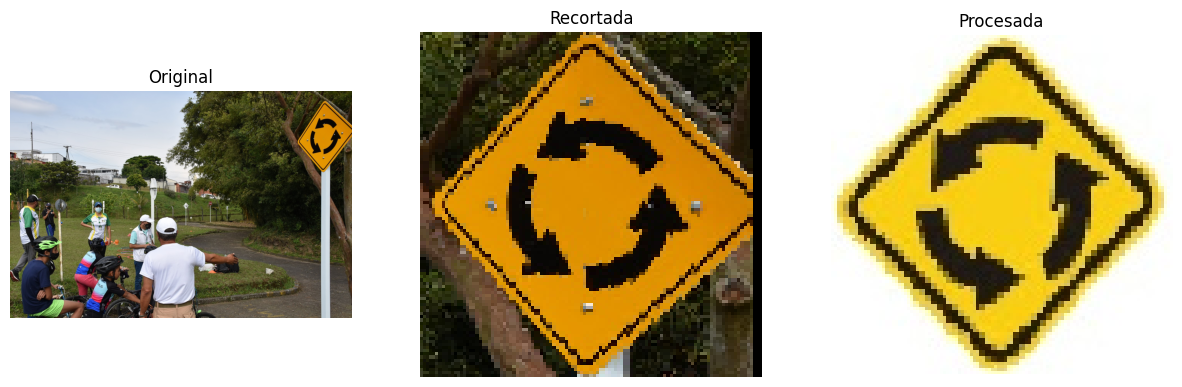

sp-04.jpg


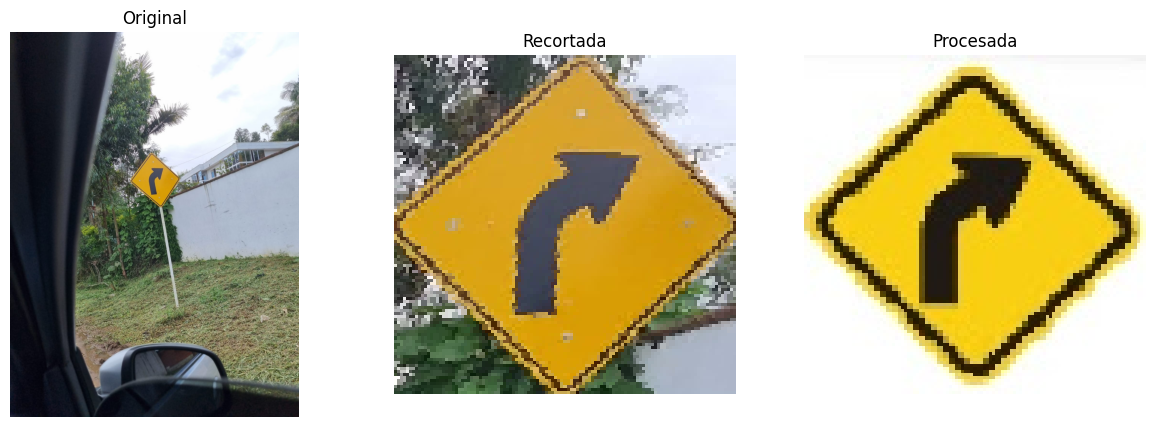

sp-02.jpg


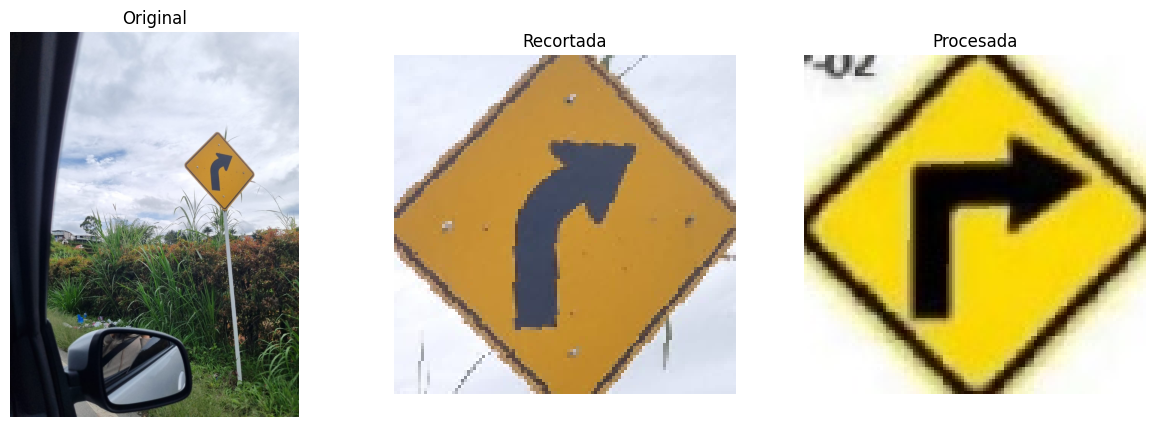

sp-09.jpg


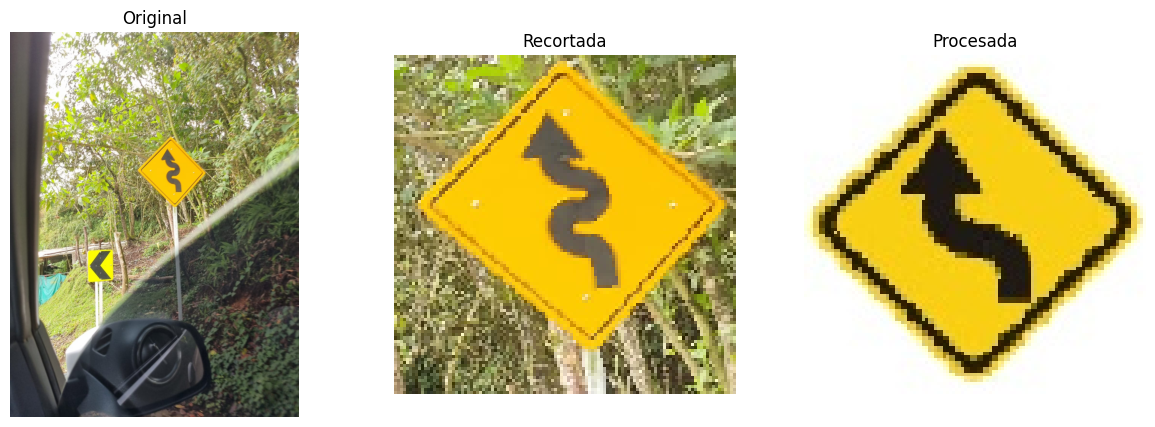

sp-25.jpg


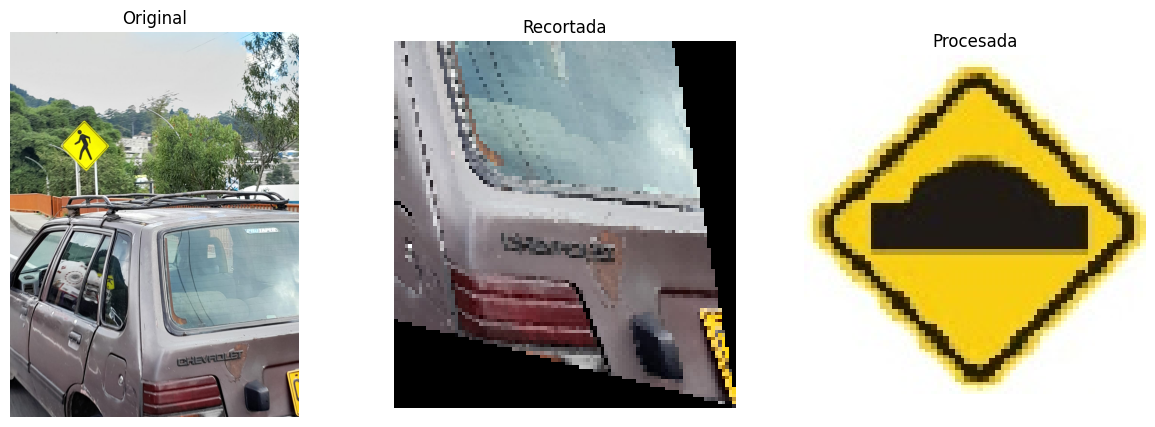

sp-25.jpg


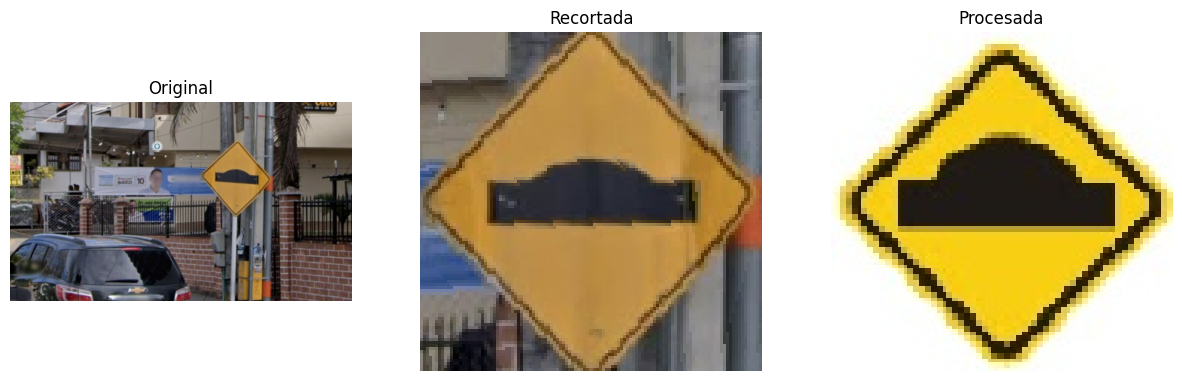

sp-25.jpg


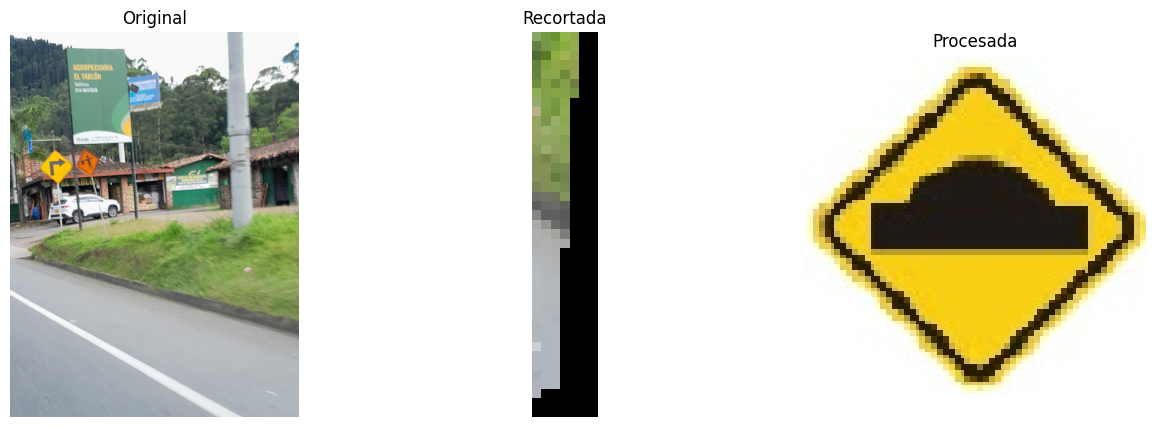

sp-25.jpg


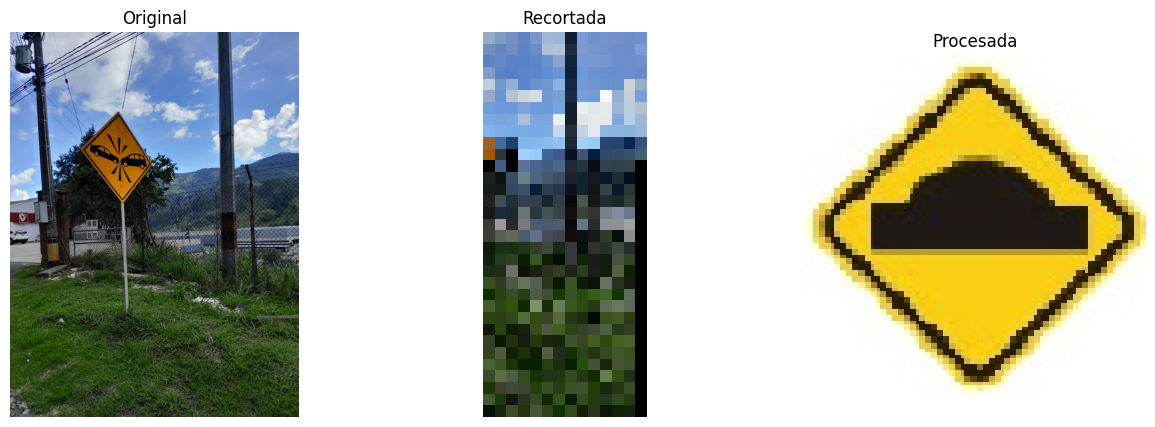

sp-02.jpg


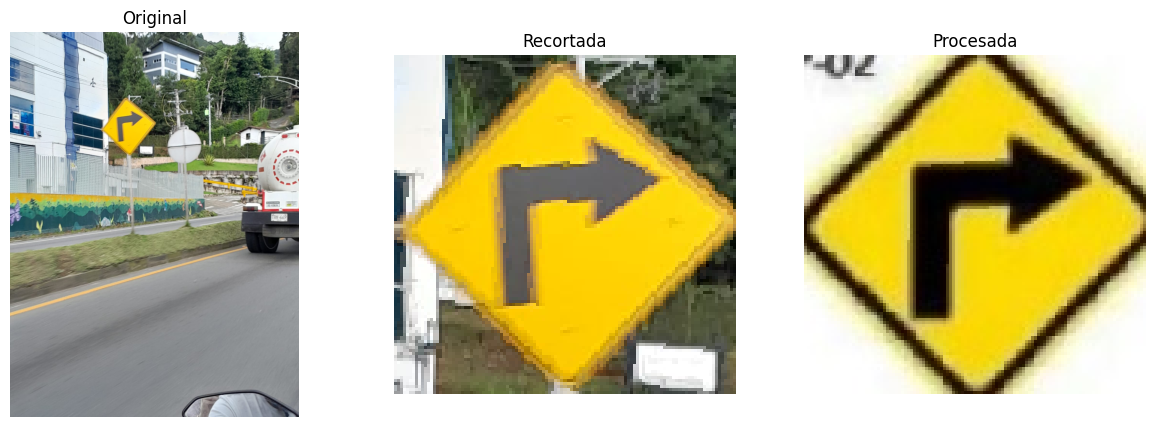

sp-12.jpg


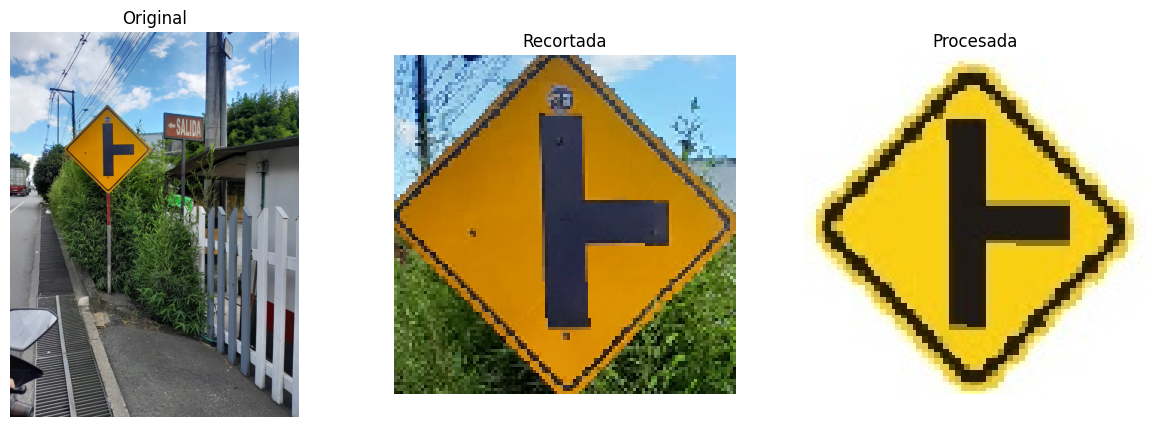

sp-46.jpg


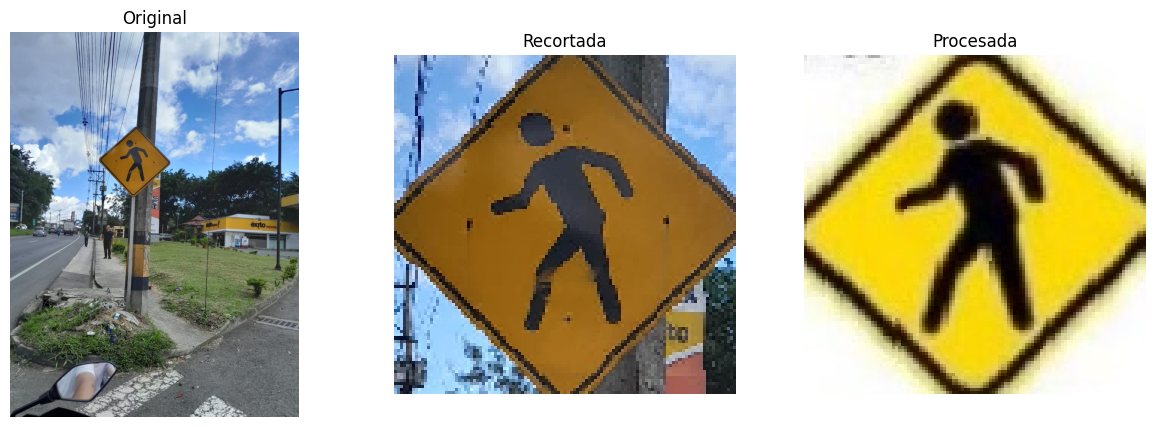

sp-04.jpg


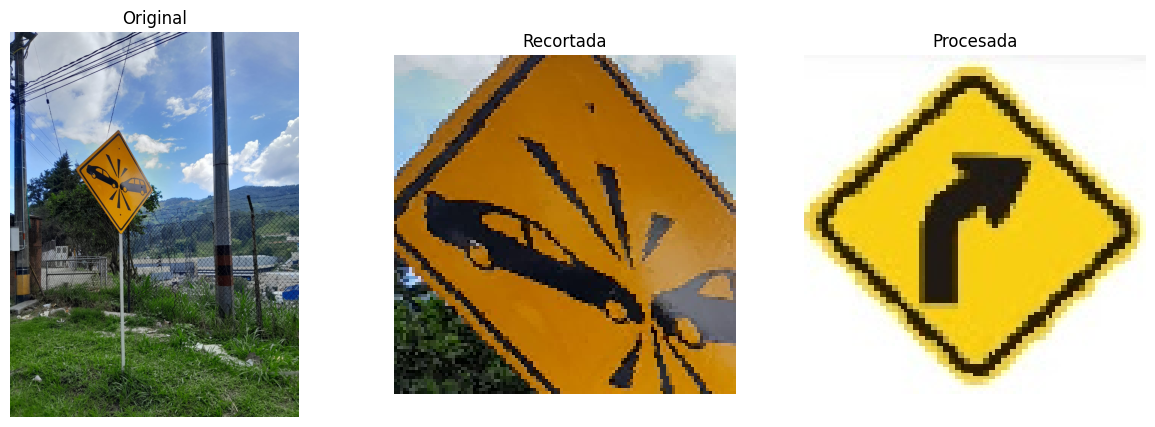

sp-47.jpg


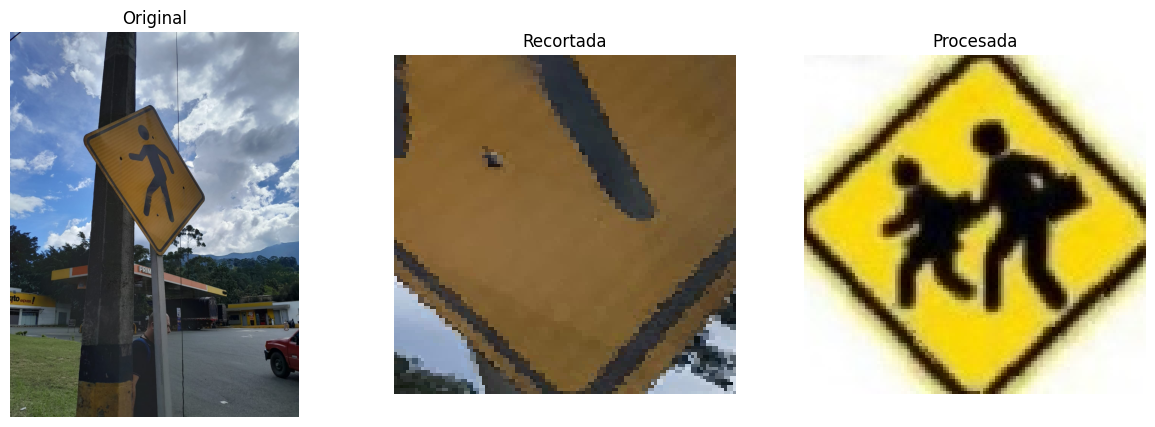

sp-19.jpg


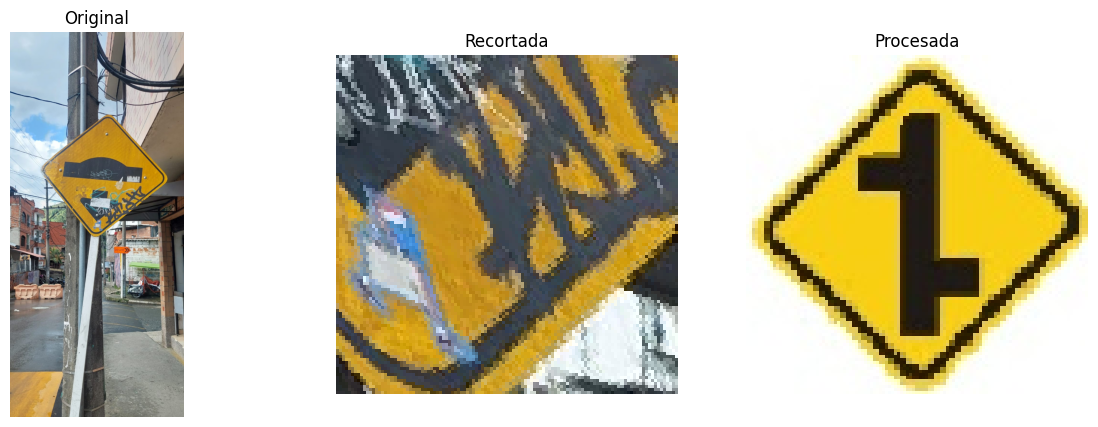

sp-02.jpg


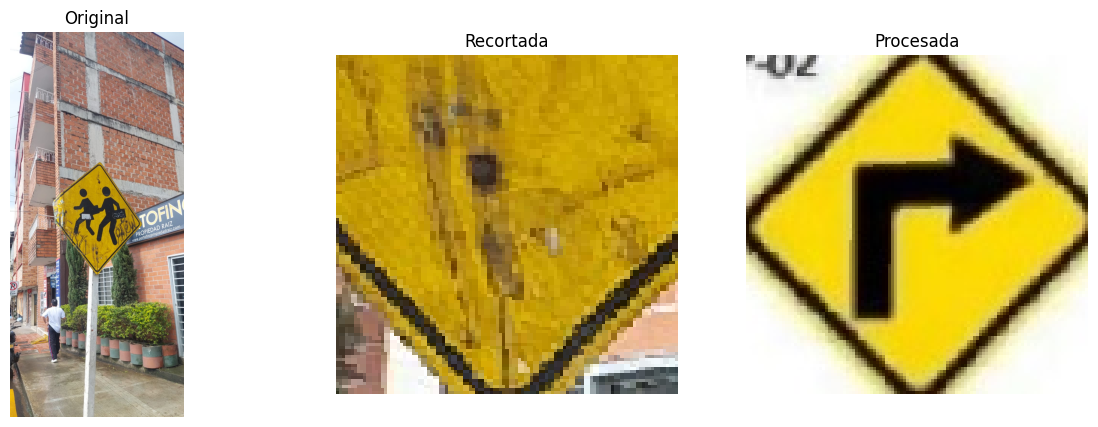

sp-01.jpg


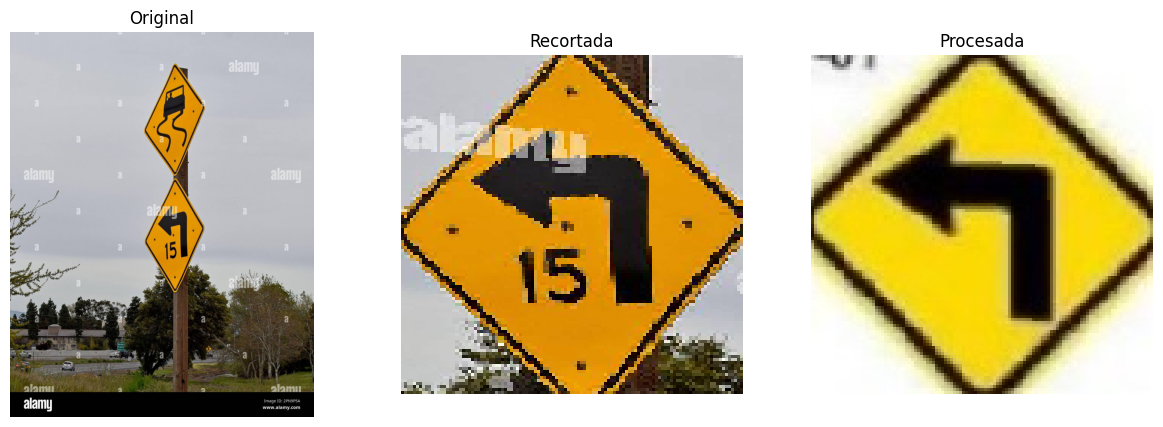

sp-04.jpg


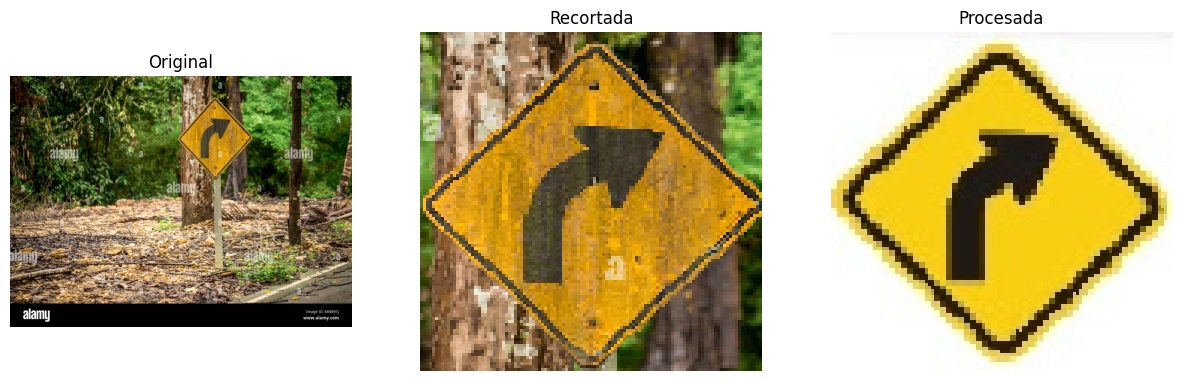

sp-19.jpg


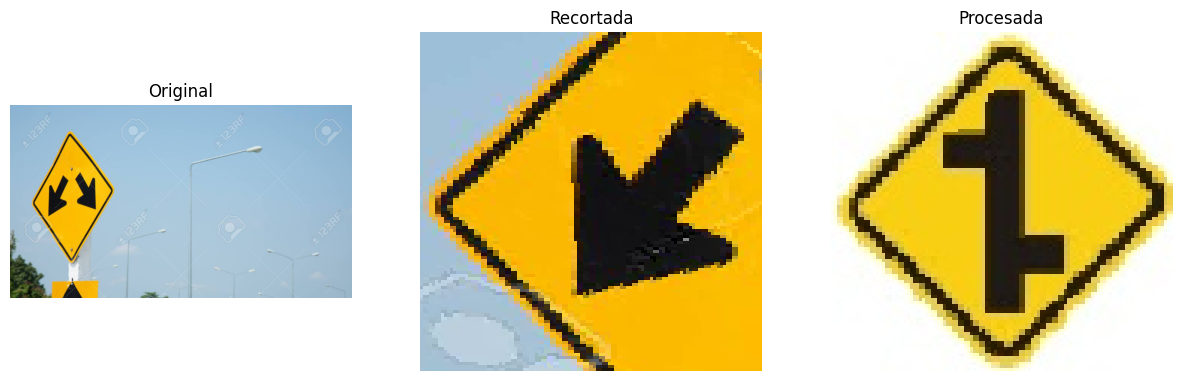

sp-25.jpg


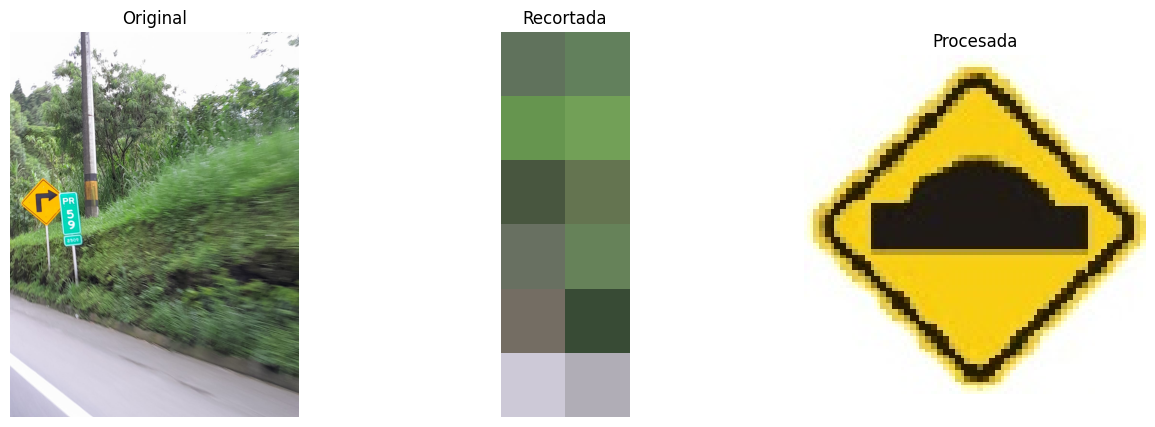

sp-47.jpg


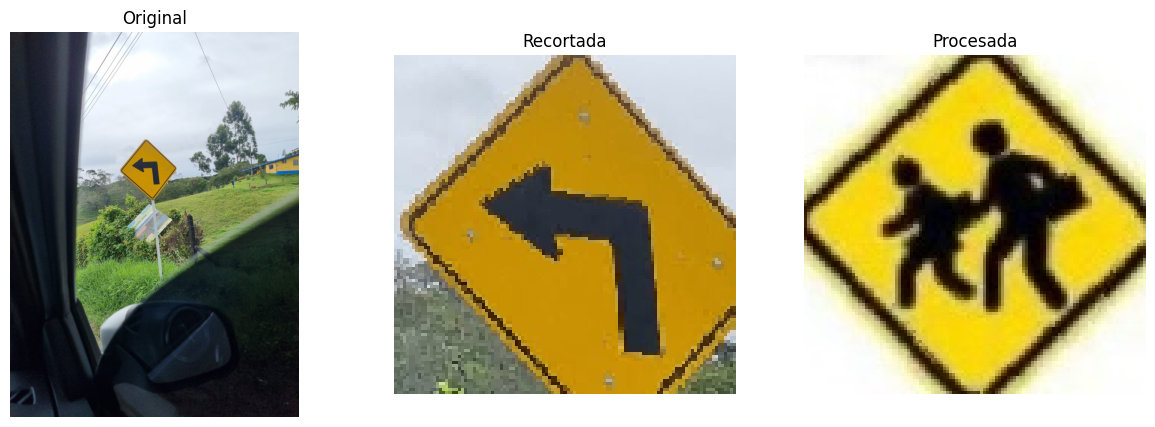

sp-01.jpg


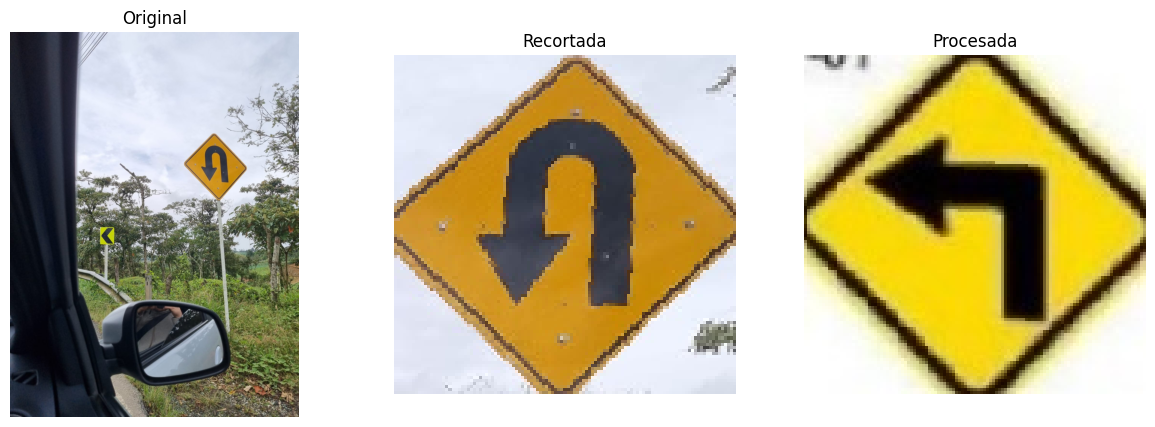

sp-25.jpg


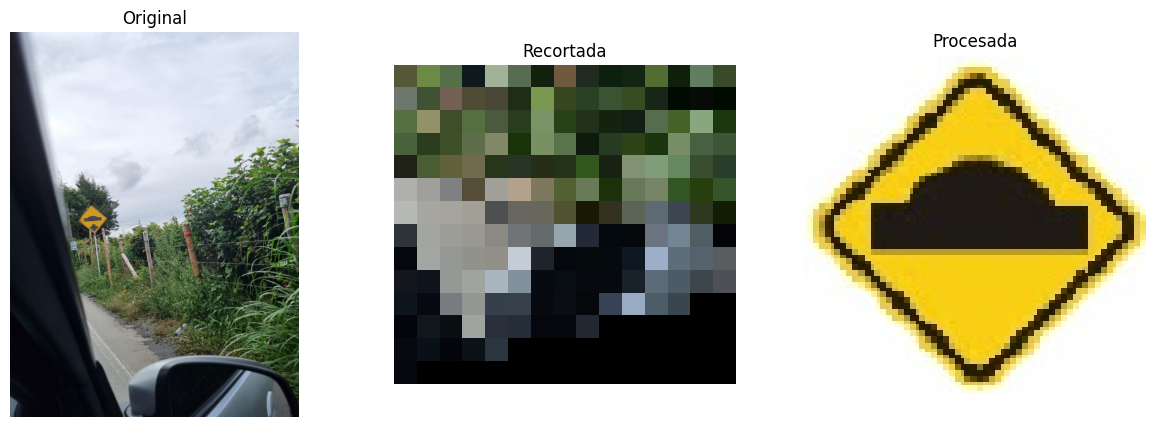

In [8]:
folder_path = 'test/'
# Inicializa listas para almacenar nombres de imágenes e imágenes
image_names = []
images = []
# Recorre todos los archivos en la carpeta
for filename in os.listdir(folder_path):
    # Verifica si el archivo es una imagen (puedes agregar más extensiones de imagen si es necesario)
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Crea la ruta completa al archivo de imagen
        img_path = os.path.join(folder_path, filename)
        
        # Lee la imagen
        img = cv2.imread(img_path)
        
        name,new_img,ps_img = traffic_signal_detector(img)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        ps_img_rgb = cv2.cvtColor(ps_img, cv2.COLOR_BGR2RGB)
        print(name)
        # Mostrar las imágenes usando Matplotlib
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(new_img_rgb)
        plt.title('Recortada')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(ps_img_rgb)
        plt.title('Procesada')
        plt.axis('off')

        plt.show()


sp-20.jpg


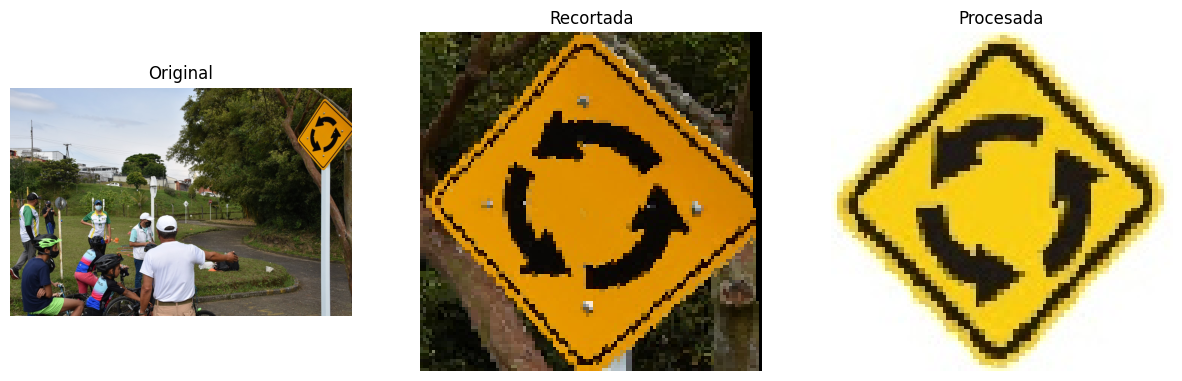

In [7]:

img = cv2.imread("test/test1.jpg")
name,new_img,ps_img=traffic_signal_detector(img)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
ps_img_rgb = cv2.cvtColor(ps_img, cv2.COLOR_BGR2RGB)
print(name)
# Mostrar las imágenes usando Matplotlib
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(new_img_rgb)
plt.title('Recortada')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(ps_img_rgb)
plt.title('Procesada')
plt.axis('off')
plt.show()